In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np


import random
from skimage.color import rgb2lab



In [18]:
base_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=( 3 , 224, 224))

for layer in base_model.layers:
    layer.trainable = False


num_layers_to_keep = 52


selected_layers = base_model.layers[:num_layers_to_keep]
model = tf.keras.Sequential(selected_layers)


for layer_base, layer_new in zip(base_model.layers[1:num_layers_to_keep], model.layers):
    layer_new.set_weights(layer_base.get_weights())


model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))


model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 112, 112)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 32, 112, 112)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 32, 112, 112)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 32, 112, 112)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 32, 112, 112)     128       
 ation)                                                          
                                                                 
 conv_dw_1_relu (ReLU)       (None, 32, 112, 112)     

In [8]:
import cv2
import numpy as np

def resize_and_pad_image(image, target_size=(224, 224), pad_color=(255, 255, 255)):

    height, width, _ = image.shape
    scale = min(target_size[0] / width, target_size[1] / height)

   
    new_width = int(width * scale)
    new_height = int(height * scale)

    
    image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)


    padded_image = np.full((target_size[1], target_size[0], 3), pad_color, dtype=np.uint8)

    
    x_offset = (target_size[0] - new_width) // 2
    y_offset = (target_size[1] - new_height) // 2

    
    padded_image[y_offset:y_offset+new_height, x_offset:x_offset+new_width] = image

    return padded_image


labels = ['ZA' , 'ZB' , 'ZC']
size = []
img_size = 240
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                img_arr = resize_and_pad_image(img_arr)
                img_arr = rgb2lab(img_arr)
                #img_arr = np.array(img_arr)
                #resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                #size.append(img_arr.shape)
                data.append([img_arr, class_num])
            except Exception as e:
                print(e)
    return data


data_dir = "images/yo"
data = get_data(data_dir)

In [9]:
np.random.shuffle(data)
split_ratio = 0.8
point = int(len(data)*0.8)
data_x = data[ : point]
data_y = data[point : ]

x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in data_x:
  x_train.append(feature)
  y_train.append(label)

for feature, label in data_y:
  x_val.append(feature)
  y_val.append(label)
    
    
x_train = np.array(x_train)
x_val = np.array(x_val)

y_train = np.array(y_train)
y_val = np.array(y_val)

x_train = np.transpose(x_train , (0,3,1,2))
x_val = np.transpose(x_val , (0,3,1,2))

from keras.utils import to_categorical

y_train1 = to_categorical(y_train)
y_val1 = to_categorical(y_val)

y_train = y_train1.astype(int)
y_val = y_val1.astype(int)

In [10]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(851, 3, 224, 224)
(851, 3)
(213, 3, 224, 224)
(213, 3)


In [12]:
def batch_generator(num, batch_size, steps):
    idx=1
    while True:
        yield load_data(num ,idx-1,batch_size)## Yields data
        if idx<steps:
            idx+=1
        else:
            idx=1
            
def load_data(num,idx,
              batch_size):

    st = idx*batch_size
    en = (idx+1)*batch_size
    if(num == 0):
      x = x_train[st : en]
      y = y_train[st : en]
    else:
      x = x_val[ st : en]
      y = y_val[st : en]

    return (x, y)

batch_size = 64
nb_epoch = 500
steps_per_epoch=np.ceil(x_train.shape[0]/batch_size)
validation_steps=np.ceil(x_val.shape[0]/batch_size)
### Generator objects for train and validation
my_training_batch_generator = batch_generator(0, batch_size,steps_per_epoch)
my_validation_batch_generator = batch_generator(1, batch_size,validation_steps)

In [14]:
checkpoint_filepath = "model_final/500k_best.h5"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [19]:
opt = Adam(lr=0.00001)
model.compile(optimizer = opt , loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

history = model.fit(my_training_batch_generator,
epochs=1000,steps_per_epoch=steps_per_epoch,
 verbose=1, validation_data=my_validation_batch_generator,
validation_steps=validation_steps,
callbacks=[model_checkpoint_callback])

Epoch 1/1000
14/14 [==============================] - 2s 97ms/step - loss: 1.1841 - accuracy: 0.2797 - val_loss: 1.1588 - val_accuracy: 0.2864
Epoch 2/1000
14/14 [==============================] - 1s 65ms/step - loss: 1.1423 - accuracy: 0.3502 - val_loss: 1.1218 - val_accuracy: 0.3521
Epoch 3/1000
14/14 [==============================] - 1s 67ms/step - loss: 1.1109 - accuracy: 0.3995 - val_loss: 1.0980 - val_accuracy: 0.4178
Epoch 4/1000
14/14 [==============================] - 1s 67ms/step - loss: 1.0924 - accuracy: 0.3655 - val_loss: 1.0842 - val_accuracy: 0.3991
Epoch 5/1000
14/14 [==============================] - 1s 74ms/step - loss: 1.0804 - accuracy: 0.4888 - val_loss: 1.0756 - val_accuracy: 0.5728
Epoch 6/1000
14/14 [==============================] - 1s 65ms/step - loss: 1.0727 - accuracy: 0.5558 - val_loss: 1.0701 - val_accuracy: 0.5211
Epoch 7/1000
14/14 [==============================] - 1s 67ms/step - loss: 1.0678 - accuracy: 0.5006 - val_loss: 1.0663 - val_accuracy: 0.4742

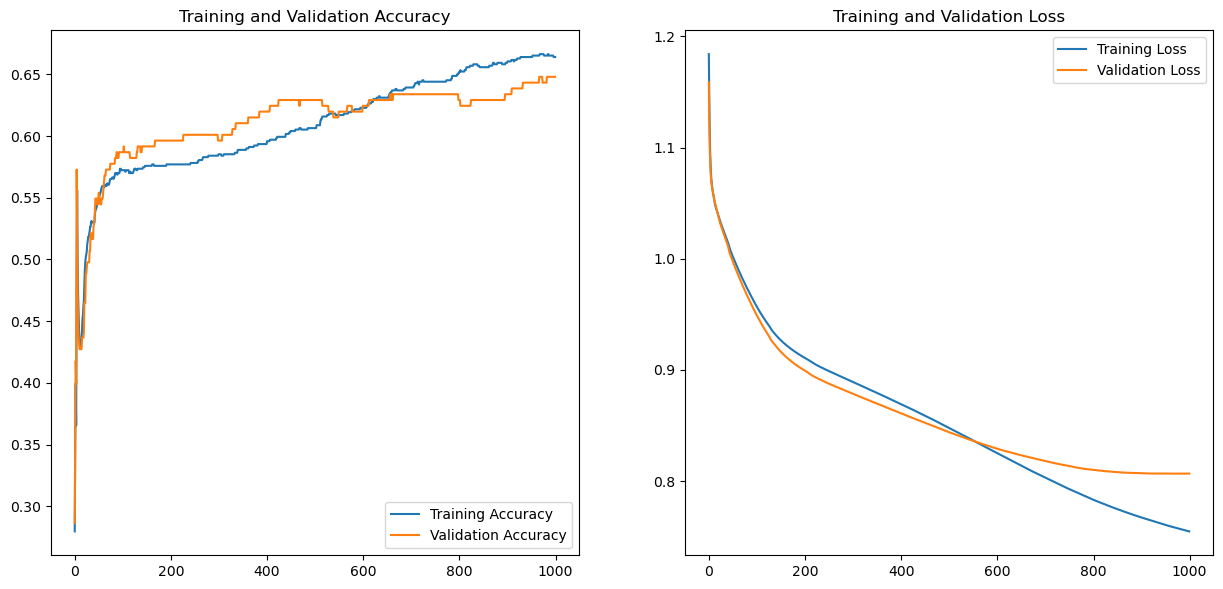

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1000)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
model.save("model_final/500k_1000epocs.h5")
model2 = load_model("model_final/500k_1000epocs.h5")

In [23]:
checkpoint_filepath = "model_final/500k_best2.h5"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [24]:
opt = Adam(lr=0.00001)
model2.compile(optimizer = opt , loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

history2 = model2.fit(my_training_batch_generator,
epochs=1000,steps_per_epoch=steps_per_epoch,
 verbose=1, validation_data=my_validation_batch_generator,
validation_steps=validation_steps,
callbacks=[model_checkpoint_callback])

Epoch 1/1000
14/14 [==============================] - 2s 103ms/step - loss: 0.7564 - accuracy: 0.6663 - val_loss: 0.8070 - val_accuracy: 0.6432
Epoch 2/1000
14/14 [==============================] - 1s 71ms/step - loss: 0.7540 - accuracy: 0.6686 - val_loss: 0.8049 - val_accuracy: 0.6526
Epoch 3/1000
14/14 [==============================] - 1s 66ms/step - loss: 0.7547 - accuracy: 0.6663 - val_loss: 0.8068 - val_accuracy: 0.6479
Epoch 4/1000
14/14 [==============================] - 1s 66ms/step - loss: 0.7542 - accuracy: 0.6675 - val_loss: 0.8062 - val_accuracy: 0.6479
Epoch 5/1000
14/14 [==============================] - 1s 68ms/step - loss: 0.7541 - accuracy: 0.6639 - val_loss: 0.8060 - val_accuracy: 0.6479
Epoch 6/1000
14/14 [==============================] - 1s 64ms/step - loss: 0.7540 - accuracy: 0.6639 - val_loss: 0.8062 - val_accuracy: 0.6479
Epoch 7/1000
14/14 [==============================] - 1s 66ms/step - loss: 0.7539 - accuracy: 0.6639 - val_loss: 0.8062 - val_accuracy: 0.647

In [25]:
model2.save("model_final/500k_2000epocs.h5")

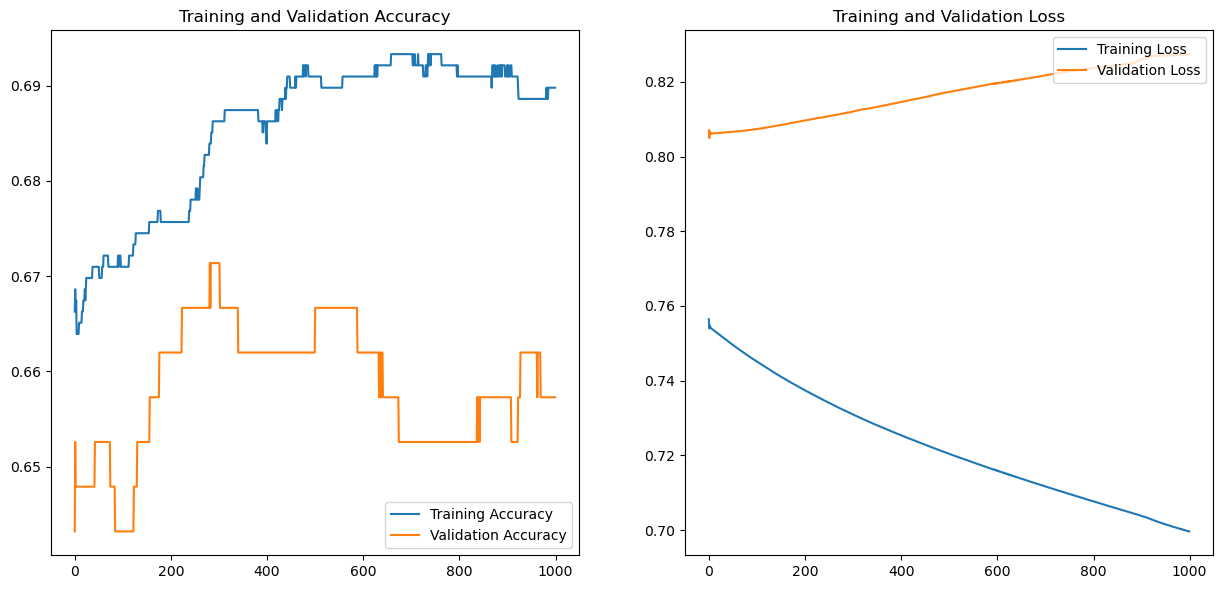

In [26]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(1000)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
model3 = load_model("model_final/500k_best2.h5")

In [29]:
model3.save_weights("model_final/model_final_weights.h5")

In [32]:
def predictor(path):
    
    if not os.path.exists(path):
        print("error: please provide a valid file path")
        return
    
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp', '.ico', '.svg' , '.jfif']
    ext = os.path.splitext(path)[1].lower()
    
    if ext not in image_extensions:
        print("please provide image as an input")
        return
        
    image = cv2.imread(path)[...,::-1]
    target_size=(224, 224)
    pad_color=(255, 255, 255)
    height, width, _ = image.shape
    scale = min(target_size[0] / width, target_size[1] / height)
    new_width = int(width * scale)
    new_height = int(height * scale)
    image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
    padded_image = np.full((target_size[1], target_size[0], 3), pad_color, dtype=np.uint8)
    x_offset = (target_size[0] - new_width) // 2
    y_offset = (target_size[1] - new_height) // 2
    padded_image[y_offset:y_offset+new_height, x_offset:x_offset+new_width] = image
    img = rgb2lab(padded_image)
    img = np.expand_dims(img, axis=0)
    img = np.transpose(img , (0,3,1,2))
    res = model3.predict(img)
    print(res)
    return np.argmax(res[0])

val_images/


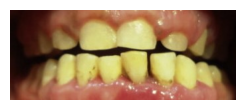

1/1 [==============================] - 1s 729ms/step
[[0.01261054 0.0704398  0.9169497 ]]
2
val_images/


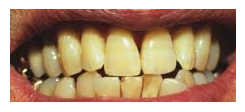

1/1 [==============================] - 0s 20ms/step
[[0.00354528 0.03331795 0.96313673]]
2
val_images/


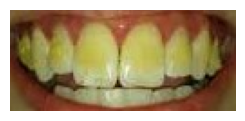

1/1 [==============================] - 0s 20ms/step
[[0.00565299 0.03612749 0.95821947]]
2
val_images/


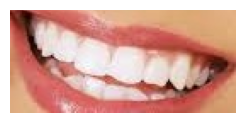

1/1 [==============================] - 0s 19ms/step
[[0.39313006 0.39982292 0.207047  ]]
1
val_images/


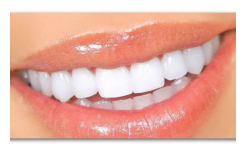

1/1 [==============================] - 0s 19ms/step
[[0.58486176 0.32011157 0.09502666]]
0
val_images/


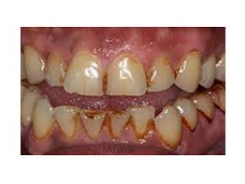

1/1 [==============================] - 0s 20ms/step
[[4.77972644e-04 1.09179085e-02 9.88604069e-01]]
2
val_images/


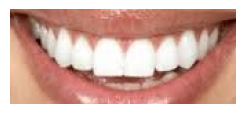

1/1 [==============================] - 0s 19ms/step
[[0.5133285  0.37915108 0.10752047]]
0
val_images/


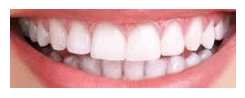

1/1 [==============================] - 0s 19ms/step
[[0.57016015 0.32635403 0.10348585]]
0


In [33]:
import matplotlib.pyplot as plt

path = "val_images/"

for images in os.listdir(path):
    path1 = path + images
    img = cv2.imread(path1)[...,::-1]
    print(path)
    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    res = predictor(path1)
    print(res)